[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLP.ipynb)

# Multilayer Perceptron (MLP)
Our goal here is to implement a two-layer neural network for binary classification, train it using gradient descent and use it to classify the Iris dataset.
Our model is
$$
\hat{y} = \sigma \left ( W \sigma \left ( V x \right ) \right)
$$
where we have $M$ hidden units and $D$ input features -- that is $w \in \mathbb{R}^{M}$, and $V \in \mathbb{R}^{M \times D}$. For simplicity here we do not include a bias parameter for each layer. Key to our implementation is the gradient calculation. We follow the notation used in the slides here.

In [2]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [25]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class MLP:
    
    def __init__(self, M = 64):
        self.M = M
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v, w = params
            z = logistic(np.dot(x, v)) #N x M
            yh = logistic(np.dot(z, w))#N
            dy = yh - y #N
            dw = np.dot(z.T, dy)/N #M
            dz = np.outer(dy, w) #N x M
            dv = np.dot(x.T, dz * z * (1 - z))/N #D x M
            dparams = [dv, dw]
            return dparams
        
        w = np.random.randn(self.M) * .01
        v = np.random.randn(D,self.M) * .01
        params0 = [v,w]
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        v, w = self.params
        z = logistic(np.dot(x, v)) #N x M
        yh = logistic(np.dot(z, w))#N
        return yh

In the implementation above we have used a list data structure to maintain model parameters and their gradients. Below I have modified the `GradientDescent` class to also work with a list of parameters. One sournce of confusion in the above implementation is the gradient calculation. While in the slides during the lectures 
we calculated the partial derivative for individual parameters, here, we use vector and matrix operations to calculate the derivative for *all* parameters. 

In [28]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

## Iris dataset
Let's apply this to do binary classification with Iris flowers dataset. 
Below we run gradient descent for a large number of iterations and plot the decision boundary.

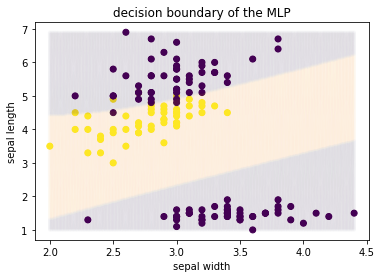

In [44]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']
y =  y == 1
model = MLP(M=32)
optimizer = GradientDescent(learning_rate=.1, max_iters=20000)
yh = model.fit(x, y, optimizer).predict(x) 
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
yh_all = model.predict(x_all) > .5
plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('decision boundary of the MLP')
plt.show()